# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [197]:
# Load pickled data
import pickle
import matplotlib.pyplot as plt
from IPython.display import Image
import pandas as pd
from matplotlib import gridspec

%matplotlib inline

# TODO: Fill this in based on where you saved the training and testing data

training_file = './data/train.p'
testing_file = './data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [198]:
### Replace each question mark with the appropriate value.
import numpy as np

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

# Some useful constants

LEARNING_RATE = 0.001
REG_PARAM = 1e-5
BATCH_SIZE = 128
EPOCHS = 100

DEV_DATA_PERCENTAGE = 0.1

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (39209, 32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

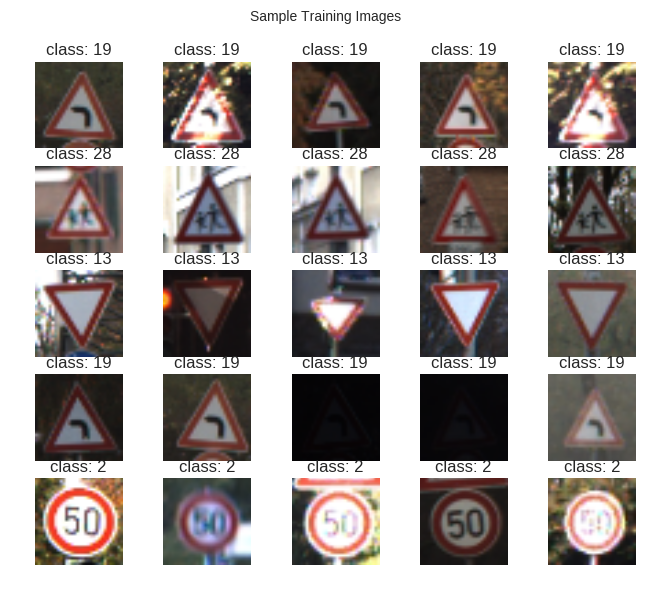

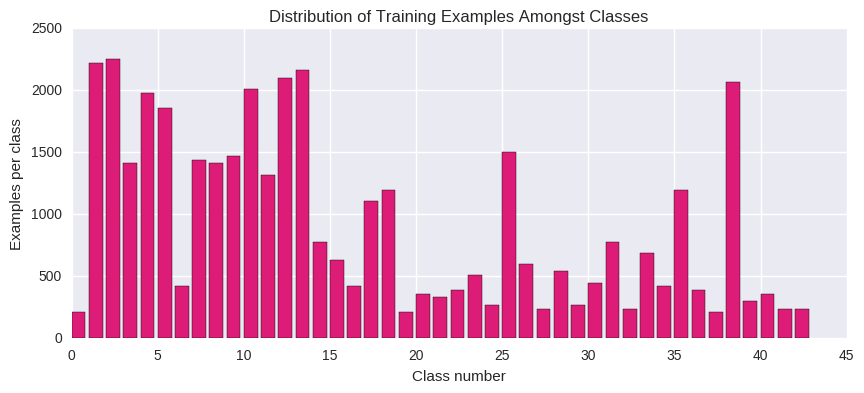

(39209, 32, 32, 3)


In [199]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import cv2

import util

%matplotlib inline

# Visualizations will be shown in the notebook.


def display_images(image_dataset, n_rows, n_cols, graph_title='Sample Training Images'):
    '''
    Simple utility function for displaying images.
    '''
    plt.figure(figsize=(8, 6.5))
    selected_classes = np.random.randint(44, size=n_rows)
    image_number = 1
    for row in selected_classes:
        for col in range(1, n_cols + 1):
            plt.subplot(n_rows, n_cols, image_number)
            image_number += 1
            x_selected = X_train[y_train == row]
            random_index = np.random.randint(x_selected.shape[0])
            plt.imshow(x_selected[random_index, :, :, :]) 
            plt.axis('off')
            plt.title('class: {}'.format(row))  
    plt.suptitle(graph_title)
    plt.show()
    
    
def draw_class_distribution(class_labels):
    '''This function is used to plot the distribution of training examples amongst classes.'''
    plt.figure(figsize=(10, 4))
    examples_per_class = np.bincount(class_labels)
    num_classes = len(examples_per_class)
    plt.bar(np.arange(num_classes), examples_per_class, 0.8, color='#dd1c77', label='Inputs per class')
    plt.xlabel('Class number')
    plt.ylabel('Examples per class')
    plt.title('Distribution of Training Examples Amongst Classes')
    plt.show()   
    
display_images(X_train, 5, 5)
draw_class_distribution(y_train)
print(X_train.shape)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

# Step: 1 Mix-Max Normalization
X_train_maxmin = util.min_max_normalization(X_train)
X_test_maxmin = util.min_max_normalization(X_test)

# Step: 2 One-Hot-Encoding
y_train, y_test = util.one_hot_encoding(y_train, y_test)

# Step: 3 train and dev split
train_features, dev_features, train_labels, dev_labels = util.train_dev_split(
    X_train_maxmin, y_train, DEV_DATA_PERCENTAGE)

training_dataset = util.DataSet(train_features, train_labels)
dev_dataset = util.DataSet(dev_features, dev_labels)
testing_dataset = util.DataSet(X_test_maxmin, y_test)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
1. Normalized data helps Gradient Descent (or similar algorithms) to converge quickly. Hence, data normalization is one of the key preprocessing steps when it comes to data preprocessing. I experimented with preprocessing techniques (namely, **MinMax Scaling** and **Mean Normalization**). But during the initial stage of the project, I found out that, MinMax Scaling works better than  Mean Normalization for this dataset. 
2. **One-Hot Encoding** was used to convert label numbers to vectors. 
3. A small percentage of training data (indicated by **DEV_DATA_PERCENTAGE**) was used as my development set.
4. In addition to that helper class ( namely:**DataSet**) was written to generate data batches.

**Note**: Those additional helpter functions and classes can be found in **util.py** file.

In [5]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
1. When it comes to training a neural network (equally applies to other learning algorithms such as Random Forest or Support Vector Machines) reliable development dataset (a.k.a. cross-validation dataset) help us to gauge the performance of the model without touching the final testing dataset. Also, proper dev dataset is essential for hyper-parameters optimization. So I used 1 percent of the original dataset as my dev dataset. (Previously recommendation was: 30-20% of your training dataset. However, this dataset consists of 39209 training examples. Hence I assume that random 10% is a good representative sample for cross-validating my model)  

2. At this point, I want to quickly design a **Minimum Viable Model** which help me to get a quick idea about the predictive performance. So I'm going to design a simple model inspaired by the famous LeNet[ref]. In addition to that, at this stage, my model will be completely based on the training dataset only (no augmented data generated). 

Epoch:0 train loss:1.6710 dev loss:1.7950 train accu:0.4453 dev accu:0.4013
Trained model saved to the disk.


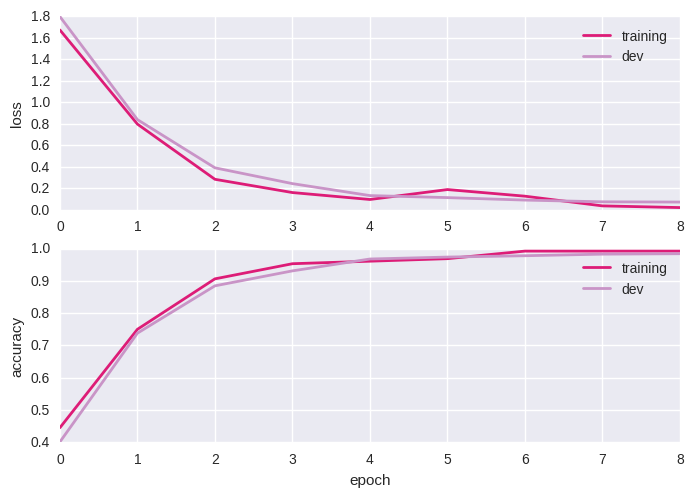

In [6]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

# some useful constants
NUM_CLASSES = 43

LEARNING_RATE = 1e-3

EPOCHS = 9

BATCH_SIZE = 128

TRAINING_FILE = './data/train.p'

TESTING_FILE = './data/test.p'

REGULARIZATION_PARAM = 1e-6

MODEL_NAME = './checkpoint_lenetplus/LeNetPlus.ckpt'

def LeNetPlus(data):
    # first conv layer
    with tf.name_scope('conv_1'):
        conv1_w = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), stddev = 0.01))
        conv1_b = tf.Variable(tf.zeros(6))
        conv1 = tf.nn.conv2d(x, conv1_w, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
        conv1 = tf.nn.relu(conv1)
        conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        
    # second conv layer
    with tf.name_scope('conv_2'):
        conv2_w = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), stddev = 0.01))
        conv2_b = tf.Variable(tf.zeros(16))
        conv2 = tf.nn.conv2d(conv1, conv2_w, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
        conv2 = tf.nn.relu(conv2)
        conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        
    # first fully connected layer
    with tf.name_scope('fc_1'):
        fc1 = flatten(conv2)
        fc1_shape = (fc1.get_shape().as_list()[-1], 1024)
        fc1_w = tf.Variable(tf.truncated_normal(shape=(fc1_shape), stddev = 0.01))
        fc1_b = tf.Variable(tf.zeros(1024))
        fc1 = tf.matmul(fc1, fc1_w) + fc1_b
        fc1 = tf.nn.relu(fc1)
        fc1 = tf.nn.dropout(fc1, keep_prob)
    
    # second fully connected layer
    with tf.name_scope('fc_2'):
        fc2_w = tf.Variable(tf.truncated_normal(shape=(1024, 1024), stddev=0.01))
        fc2_b = tf.Variable(tf.zeros(1024))
        fc2 = tf.matmul(fc1, fc2_w) + fc2_b
        fc2 = tf.nn.relu(fc2)
        fc2 = tf.nn.dropout(fc2, keep_prob)
    
    # logit 
    with tf.name_scope('logit'):
        logit_w = tf.Variable(tf.truncated_normal(shape=(1024, NUM_CLASSES), stddev = 0.01))
        logit_b = tf.Variable(tf.zeros(NUM_CLASSES))
        return (tf.matmul(fc2, logit_w) + logit_b), [conv1_w, conv2_w, fc1_w, fc2_w, logit_w] 
    
def regularization_cost(weights, regularization):
    reg_cost = 0.0
    for weight in weights:
        reg_cost += regularization * tf.nn.l2_loss(weight)
    return reg_cost

# placeholders for input images, labels and dropout percentage
x = tf.placeholder("float", [None, 32, 32, 3])
tf.add_to_collection("x", x)  # Remember this Op.

y = tf.placeholder("float", [None, NUM_CLASSES])
tf.add_to_collection("y", y) 

keep_prob = tf.placeholder(tf.float32)
tf.add_to_collection("keep_prob", keep_prob) 

logits, weights = LeNetPlus(x)
tf.add_to_collection("logits", logits)

loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y)) + \
          regularization_cost(weights, REGULARIZATION_PARAM)
tf.add_to_collection('loss_op', loss_op)

optimizer = tf.train.AdamOptimizer(LEARNING_RATE)
train_op = optimizer.minimize(loss_op)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.add_to_collection('accuracy_op', accuracy_op)

def eval_data(dataset):
    steps_per_epoch = dataset.length() // BATCH_SIZE
    num_examples = steps_per_epoch * BATCH_SIZE
    total_acc, total_loss = 0, 0
    for step in range(steps_per_epoch):
        batch_x, batch_y = dataset.next_batch(BATCH_SIZE)
        loss, acc = sess.run([loss_op, accuracy_op], 
                             feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_acc += (acc * batch_x.shape[0])
        total_loss += (loss * batch_x.shape[0])
    return total_loss / num_examples, total_acc / num_examples

saver = tf.train.Saver()
best_dev_acc = 1e-10

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    steps_per_epoch = len(train_features) // BATCH_SIZE
    num_examples = steps_per_epoch * BATCH_SIZE
    
    training_accuracies = []
    dev_accuracies = []

    training_losses = []
    dev_losses = []
    
    for epoch in range(EPOCHS):
        
        for step in range(steps_per_epoch):
            batch_x, batch_y = training_dataset.next_batch(BATCH_SIZE)
            loss, accur = sess.run([train_op, accuracy_op],
                                   feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})        
        
        # training loss and accuracy after an epoch
        loss_tr, acc_tr = sess.run([loss_op, accuracy_op], 
                                   feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})        
        training_losses.append(loss_tr)
        training_accuracies.append(acc_tr)

        loss_dev, acc_dev = eval_data(dev_dataset)
        dev_accuracies.append(acc_dev)
        dev_losses.append(loss_dev)
        
        if acc_dev > best_dev_acc:                
                saver.save(sess, MODEL_NAME, global_step=step)
                best_dev_acc = acc_dev
        
        if epoch % 20 == 0:
            print('Epoch:{:d} train loss:{:.4f} dev loss:{:.4f} train accu:{:.4f} dev accu:{:.4f}'.format(
                    epoch, loss_tr, loss_dev, acc_tr, acc_dev))      
    
    print('Trained model saved to the disk.')
    util.plot_learning_curves(training_losses, training_accuracies, dev_losses, dev_accuracies)

### Is My Simple Convolutional Neural Network Good Enough?
Above graph shows the accuracy and loss function for our simple convolutional neural network. Also I trained another model with 1024 and 512 fully connected layers. The loss function and accuracy of that model is given below (performance graph is shown below).

By looking at these two model, it looks like convolution network with 1024 and 1024 fully connected layers is better than the one which has 1024 and 512 fully connected layers.

Next, I'm going to generate some additional data and trained my first convolutional model (that is the one which as two (1024 and 1024) fully connected layers. 

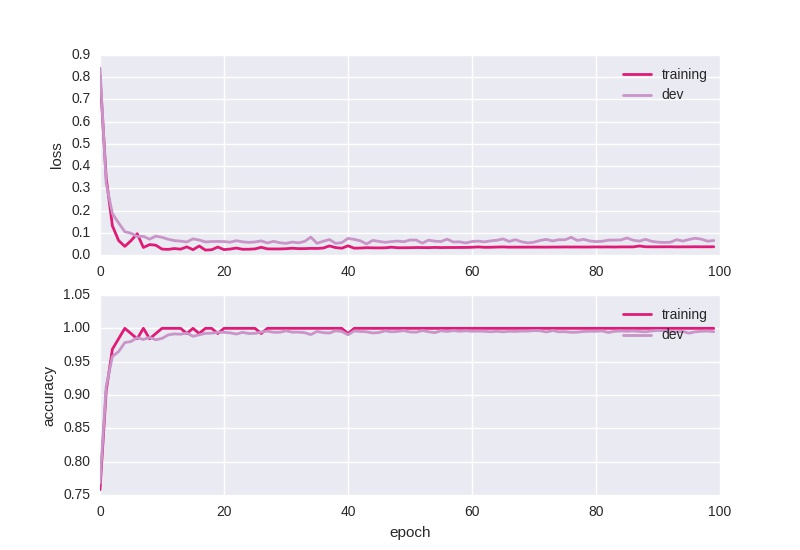

In [7]:
Image('./images/learning_curves_1024_512_fully_connected.jpg')

### How Do I Generate Additional Training Data?
For each image to the training dataset, small random Rotation, Translation and Shear operation was applied. So by using this approach I was able to double my training dataset. The Python code (**transform_image** method) I used to generate augmented data is given in **util.py** file.

Following shows sample augmented images generated by using **transform_image** method.

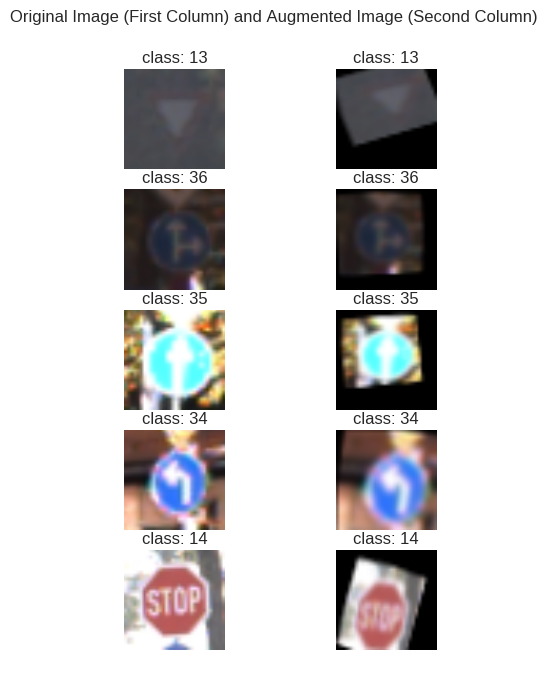

In [8]:
def display_augmented_images(image_dataset, augmented_data, n_rows):
    '''
    Simple utility function for displaying augmented images.
    '''
    plt.figure(figsize=(5,7.5))
    selected_classes = np.random.randint(0, 44, size=n_rows)
    image_number = 1
    for row in selected_classes:
        x_selected = X_train[np.argmax(y_train, axis=1) == row]
        index = 0 # print first image of each image category
        
        plt.subplot(n_rows, 2, image_number)
        plt.imshow(x_selected[index, :, :, :]) 
        plt.axis('off')
        plt.title('class: {}'.format(row)) 
        image_number += 1
        
        aug_selected = augmented_data[np.argmax(y_train, axis=1) == row]
        
        plt.subplot(n_rows, 2, image_number)
        plt.imshow(aug_selected[index, :, :, :]) 
        plt.axis('off')
        plt.title('class: {}'.format(row))
        image_number += 1
        
    plt.suptitle('Original Image (First Column) and Augmented Image (Second Column)')
    plt.show()
    
    
X_train_transformed = np.zeros_like(X_train)
y_train_transformed = np.zeros_like(y_train)

for i in range(X_train_transformed.shape[0]): #
    X_train_transformed[i] = util.transform_image(X_train[i], 20, 10, 5)
    y_train_transformed[i] = y_train[i]        

display_augmented_images(X_train, X_train_transformed, 5)

Performance graph of the neural network one (i.e. 6 and 16 convolution layers and 1024 and 1024 fully connected layers) is given below.

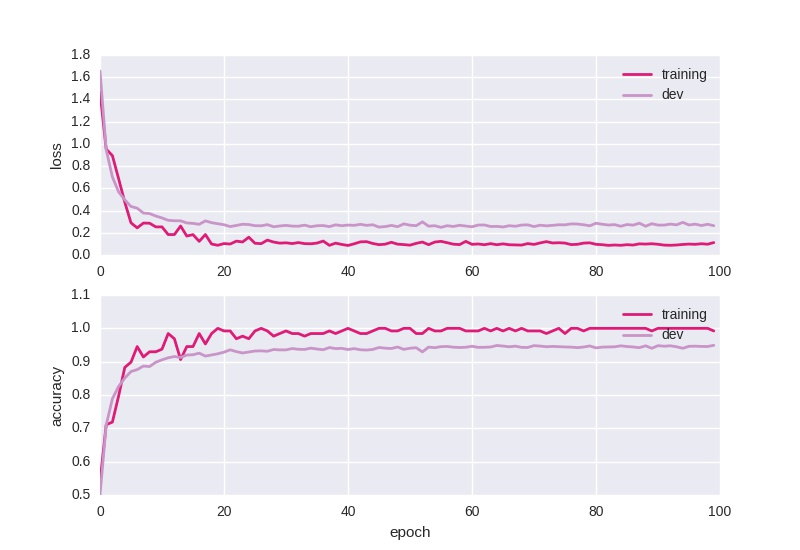

In [9]:
Image('./images/learning_curves_with_augmented_data.jpg')

By considering all three graphs, I decided first model (6 and 16 convolution layer, 1024 and 1024 fully connected layers, running without augmented data) is the current best model. So I tested its performance using testing dataset is given below.

In [10]:
with tf.Session(graph = tf.Graph()) as sess:
    saver = tf.train.import_meta_graph('./checkpoint_lenetplus/LeNetPlus.ckpt-274.meta')
    saver.restore(sess,  tf.train.latest_checkpoint('./checkpoint_lenetplus'))
        
    # Retrieve the Ops we 'remembered'.
    x = tf.get_collection("x")[0]
    y = tf.get_collection("y")[0]
    keep_prob = tf.get_collection("keep_prob")[0]
    logits = tf.get_collection('logits')[0]
    accuracy_op = tf.get_collection('accuracy_op')[0]
    loss_op = tf.get_collection('loss_op')[0]
        
    model_loss, model_perf = eval_data(testing_dataset)
    print('Test Dataset Classification Accuracy: {:.4f}'.format(model_perf))

Test Dataset Classification Accuracy: 0.9136


### Building Convolution Networks: Beyond Simple Models
So far we are mainly working on a simple neural network and it had only two convolution layers.  With that simple model, we managed to get 95.42% accuracy on the testing dataset. 

However, as accuracy/loss graphs suggest it didn't work so well when we increase the dataset with augmented data.Hence, it decided to create a little bit big model with following configuration. Hence, it decided to create a little bit big model. Its architecture is also given below. 

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
1. When I start a new machine learning project usually I start with a very simple algorithm. That approach helps me quickly build a model and experiment with the dataset. So in this project also I used that approach and build a simple convolutional neural network as my first attempt.
2. So my first model inspired by LeNet has the following configuration.
   1. First convolutional layer: 5x5 kernel, stride of 1, depth of 6, VALID padding.
   2. Max pooling layer: 2x2 kernal with stride of 2
   3. Second convolutional layer: 5x5 kernel, stride of 1, depth of 16, VALID padding.
   4. Max pooling layer: 2x2 kernal with stride of 2
   5. Fully connected layer of size 1024
   6. Dropout layer with dropout probability 0.5
   7. Fully connected layer of size 1024
   8. Dropout layer with dropout probability 0.5
   9. Finally, a softmax layer with size 43
3. For regularization I used dropout (with probability: 0.5) and $L_2$ regularizer with small regularization parameter.

**Architecture of my second model: **
 1. First convolutional layer: 3x3 kernel, stride of 1, depth of 64, SAME padding.
 2. Max pooling layer: 2x2 kernal with stride of 2 
 3. Second convolutional layer: 3x3 kernel, stride of 1, depth of 64, SAME padding.
 4. Max pooling layer: 2x2 kernal with stride of 2 
 5. Second convolutional layer: 3x3 kernel, stride of 1, depth of 128, VALID padding.
 6. Max pooling layer: 2x2 kernal with stride of 2 
 7. Fully connected layer of size 1024
 8. Dropout layer with dropout probability 0.5 
 9. Fully connected layer of size 1024
 10. Dropout layer with dropout probability 0.5 
 11. Finally, a softmax layer with size 43

In [11]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

**First Model:**
1. Optimizer: AdamOptimizer
2. Learning Rate: 1e-3
3. Epochs:  100
4. Batch Size: 128
5. Regularization Parameter: 1e-6

**Second Model:**
1. Optimizer: AdamOptimizer
2. Learning Rate: 1e-3
3. Epochs:  120
4. Batch Size: 128
5. Regularization Parameter: 1e-6

Also, note that my second model was run as a standard Python file (namely: **lenet_dropput_64_64_128_1024_1024.py**) and based on the cross-validation ( a.k.a. dev) set accuracy best model was saved into the disk. The exercises of the rest of the notebook were run against that model. Its loss/accuracy graphs and performance against testing dataset are given below.

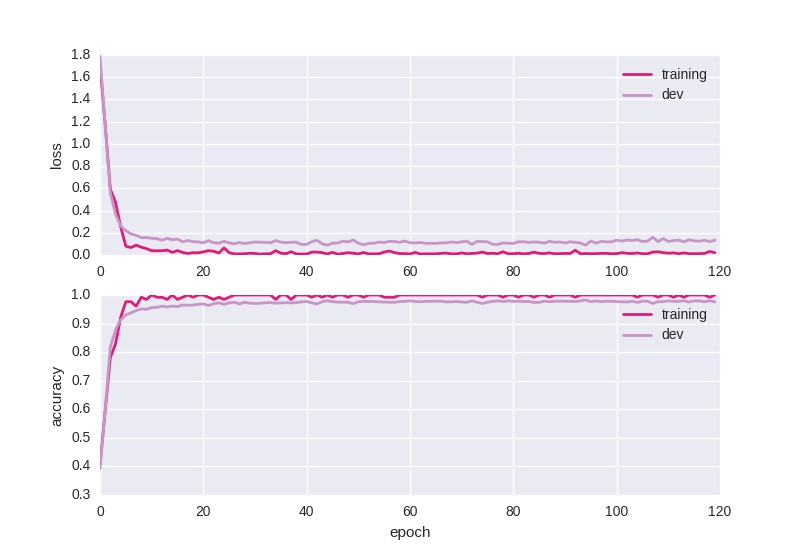

In [12]:
Image('./images/learning_curves_64_64_128_1024_1024.jpg')

In [13]:
with tf.Session(graph = tf.Graph()) as sess:
    saver = tf.train.import_meta_graph(
        './checkpoint_64_64_128_1024_1024/LeNetPlusPlus_64_64_128_1024_1024.ckpt-550.meta')
    saver.restore(sess,  tf.train.latest_checkpoint('./checkpoint_64_64_128_1024_1024'))
        
    # Retrieve the Ops we 'remembered'.
    x = tf.get_collection("x")[0]
    y = tf.get_collection("y")[0]
    keep_prob = tf.get_collection("keep_prob")[0]
    logit = tf.get_collection('logit')[0]
    accuracy_op = tf.get_collection('accuracy_op')[0]
    loss_op = tf.get_collection('loss_op')[0]
        
    model_loss, model_perf = eval_data(testing_dataset)
    print('Test Dataset Classification Accuracy: {:.4f}'.format(model_perf))

Test Dataset Classification Accuracy: 0.9662


### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
I started the model building process I used a well-known architecture called LeNet. The main reasons for selecting that model was
1. Well-known model and perform well on computer vision tasks.
2.  Easy to train even on a decent laptop.

At the initial stage, I didn't use additional synthetic data. However, even without those additional data, I managed to get  95.42% accuracy. 

But this neural network architecture didn't work so well when I add some additional synthetic data (please look the graphs). So I decided to use a little bit big network. The main reson for me to select mid-size convolutional neural network was my computational budget.

Also, loss/accuracy graphs of that network suggest, there is a possibility of pushing the accuracy little a bit further if the increase the size ( number of layers, computational units per layer and etc.) of the network.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

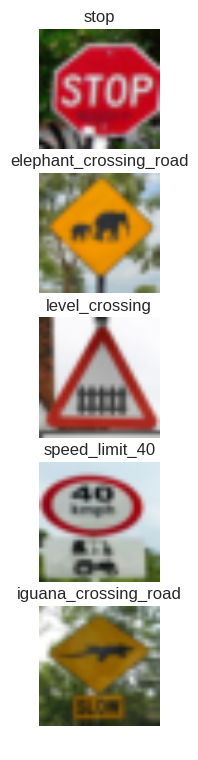

In [179]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

import os
import scipy.misc

NEW_IMAGES_FOLDER = './new_images/'

labels = {0: 'stop',
          1: 'elephant crossing road',
          2: 'level crossing',
          3: 'speed limit 40 km/h',
          4: 'iguana crossing road'}

def resize_image(image_file):
    image = plt.imread(NEW_IMAGES_FOLDER + image_file)
    return scipy.misc.imresize(image, (32, 32))

resized_image_data = [(resize_image(image), image[:-4]) 
                          for image in os.listdir(NEW_IMAGES_FOLDER)]

def display_images(imgs_data):
    index = 1
    plt.figure(figsize=(4,9))
    for img, name in imgs_data:
        plt.subplot(5, 1, index)
        plt.imshow(img)
        plt.axis('off')
        plt.title(name)
        index += 1
    plt.show()
    
display_images(resized_image_data)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

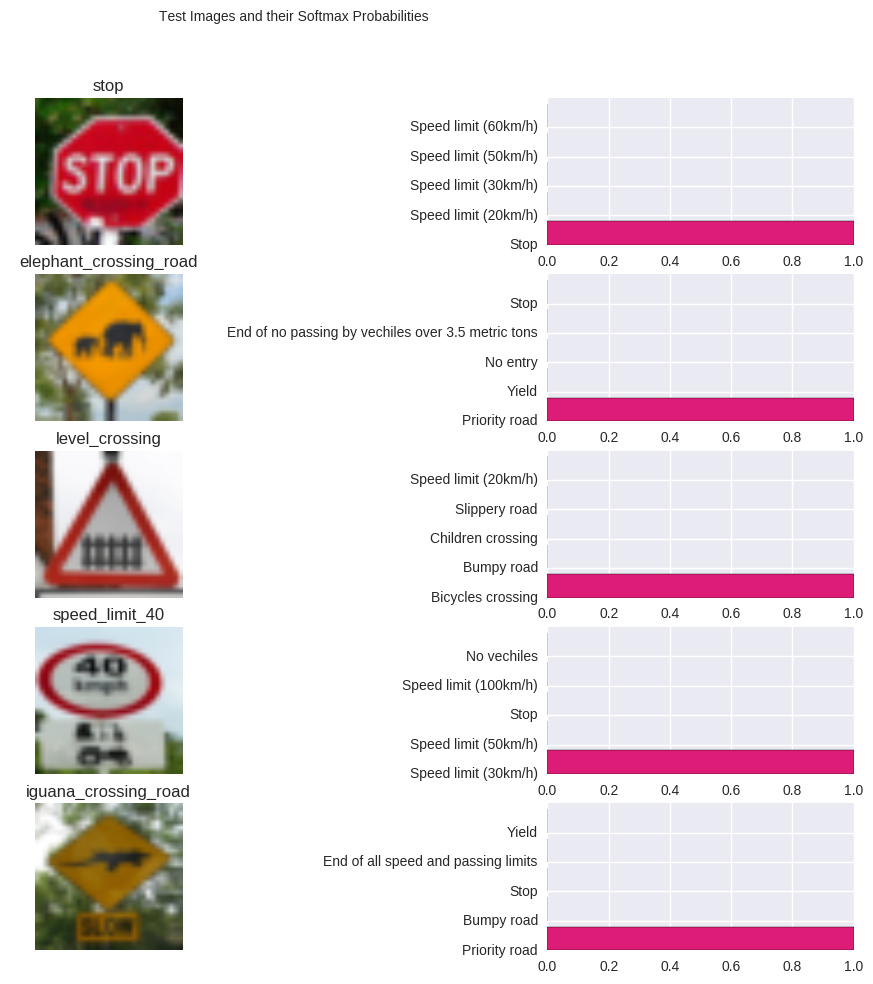

In [196]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

resized_images = [img_and_name[0] for img_and_name in resized_image_data]
X_test_new_dataset = util.min_max_normalization(np.array(resized_images))

def print_result(ground_truth, top_k_prob, top_k_indices):
    class_names = pd.read_csv('./data/signnames.csv')['SignName'].values
    #print(class_names[top_k_indices])
    index = 0
    img_index = 0
    plt.figure(figsize=(14, 11))
    gs = gridspec.GridSpec(5, 2, width_ratios=[1, 0.45]) 
    for key in ground_truth:
        img, tag = resized_image_data[img_index]
        img_index += 1
        plt.subplot(gs[index])
        plt.imshow(img)
        plt.axis('off')
        plt.title(tag)
        index += 1
        
        #print(key)
        #print(class_names[top_k_indices[key, :]])
        #print(top_k_prob[key, :])
        plt.subplot(gs[index])
        plt.barh(np.arange(1, 6, 1), top_k_prob[key, :], 
        0.8, color='#dd1c77', label='Inputs per class')
        plt.yticks(np.arange(1, 6, 1), class_names[top_k_indices[key, :]])
        #plt.title('Softmax Probabilities')
        #plt.axis('off')
        index += 1
        #print('\n')
    plt.suptitle('Test Images and their Softmax Probabilities')
    plt.show()
    
    

with tf.Session(graph = tf.Graph()) as sess:
    saver = tf.train.import_meta_graph(
        './checkpoint_64_64_128_1024_1024/LeNetPlusPlus_64_64_128_1024_1024.ckpt-550.meta')
    saver.restore(sess,  tf.train.latest_checkpoint('./checkpoint_64_64_128_1024_1024'))
        
    # Retrieve the Ops we 'remembered'.
    x = tf.get_collection("x")[0]
    y = tf.get_collection("y")[0]
    keep_prob = tf.get_collection("keep_prob")[0]
    logits = tf.get_collection('logit')[0]
    softmax = tf.nn.softmax(logits)
    normalized_prob = sess.run(softmax, feed_dict={x: X_test_new_dataset, keep_prob: 1.0})
    #print(np.argmax(normalized_prob, axis=1))
    #print_result(labels, normalized_prob)
    
    top_k_op = tf.nn.top_k(normalized_prob, k=5)
    top_k_results = sess.run(top_k_op)
    
    print_result(labels, top_k_results.values, top_k_results.indices)

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [16]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.